In [ ]:
import os
import shutil
import yaml
import time, timeit
from collections import namedtuple
import numpy as np
import torch
import torch.nn.functional as F
from thinker.actor_net import ActorNet
from thinker.main import Env
import thinker.util as util
from thinker.self_play import init_env_out, create_env_out


class DetectBuffer:
    def __init__(self, outdir, t, rec_t, logger, delay_n=5):
        """
        Store training data grouped in planning stages and output
        whenever the target output is also readydd
            Args:
                N (int): number of planning stage per training output
                delay_n (int): number of planning stage delayed in the output y
                rec_t (int): number of step in a planning stage
                K (int): number of block to merge into
        """
        self.outdir = outdir
        self.t = t # number of time step per file
        self.rec_t = rec_t
        self.logger = logger        
        self.delay_n = delay_n        

        self.processed_n, self.xs, self.y, self.done, self.step_status = 0, [], [], [], []
        self.file_idx = -1
    
    def insert(self, xs, y, done, step_status):
        """
        Args:
            xs (dict): dictionary of training input, with each elem having the
                shape of (B, *)            
            y (tensor): bool tensor of shape (B), being the target output delayed by
                delay_n planning stage            
            done (tensor): bool tensor of shape (B), being the indicator of episode end
            step_status (int): int indicating current step status
        Output:
            save train_xs in shape (N, rec_t, B, *) and train_y in shape (N, B)
        """
        #print("data received! ", y.shape, id, cur_t)
        last_step_real = (step_status == 0) | (step_status == 3)
        if len(self.step_status) == 0 and not last_step_real: return self.file_idx  # skip until real step
                
        self.xs.append(util.dict_map(xs, lambda x:x.cpu()))
        self.y.append(y.cpu())
        self.done.append(done.cpu())
        self.step_status.append(step_status)
        self.processed_n += int(last_step_real)

        if (self.processed_n >= self.t + self.delay_n + 1):               
            self.file_idx += 1                     
            out = self._extract_data(self.t)
            self.processed_n = sum([int(i == 0) + int(i == 3) for i in self.step_status])
            assert self.processed_n == self.delay_n+1, f"should only have {self.delay_n + 1} data left instead of {self.processed_n}"
            path = f'{self.outdir}/data_{self.file_idx}.pt'
            torch.save(out, path)
            out_shape = out[0]['env_state'].shape
            n = self.file_idx * out_shape[0] * out_shape[2]
            self.logger.info(f"{n}: File saved to {path}; env_state shape {out_shape}")

        return self.file_idx   

    def _extract_data(self, t):
        # obtain the first N planning stage and the corresponding target_y in data
        xs, y, done, step_status = self._collect_data(t)
        future_y, future_done = self._collect_data(self.delay_n, y_done_only=True)
        y = torch.concat([y, future_y], dim=0)
        done = torch.concat([done, future_done], dim=0)                
        
        last_step_real = (step_status == 0) | (step_status == 3)
        assert last_step_real[0], "cur_t should start with 0"
        assert last_step_real.shape[0] == t*self.rec_t, \
            f" step_status.shape is {last_step_real.shape}, expected {t*self.rec_t} for the first dimension."        
        assert y.shape[0] == (t + self.delay_n)*self.rec_t, \
            f" y.shape is {y.shape}, expected {(t + self.delay_n)*self.rec_t} for the first dimension."        
        
        B = y.shape[1]
        y = y.view(t + self.delay_n, self.rec_t, B)[:, 0]
        done = done.view(t + self.delay_n, self.rec_t, B)[:, 0]
        step_status = step_status.view(t, self.rec_t)
        # compute target_y
        
        target_y = self._compute_target_y(y, done, self.delay_n)

        for k in xs.keys():
            xs[k] = xs[k].view((t, self.rec_t) + xs[k].shape[1:])
        
        
        for i in range(t):
            print(i, " y", y[i, 2].item(), " target_y ", target_y[i, 2].item(), " done ", done[i, 2].item(), " cost ", xs['cost'][i, 0, 2].item())
        
        xs["done"] = done[:t]
        xs["step_status"] = step_status
                
        return xs, target_y

    def _collect_data(self, t, y_done_only=False):
        # collect the first t stage from data
        step_status = torch.tensor(self.step_status, dtype=torch.long)
        next_step_real = (step_status == 2) | (step_status == 3)        
        idx = torch.nonzero(next_step_real, as_tuple=False).squeeze()    
        last_idx = idx[t-1] + 1
        y = torch.stack(self.y[:last_idx], dim=0)
        done = torch.stack(self.done[:last_idx], dim=0)
        if not y_done_only:
            xs = {}
            for k in self.xs[0].keys():
                xs[k] = torch.stack([v[k] for v in self.xs[:last_idx]], dim=0)                
            step_status = step_status[:last_idx]
            self.xs = self.xs[last_idx:]
            self.y = self.y[last_idx:]
            self.done = self.done[last_idx:]
            self.step_status = self.step_status[last_idx:]
            return xs, y, done, step_status
        else:
            return y, done
        
    def _compute_target_y(self, y, done, delay_n):        
        # target_y[i] = (y[i] | (~done[i+1] & y[i+1]) | (~done[i+1] & ~done[i+2] & y[i+2]) | ... | (~done[i+1] & ~done[i+2] & ... & ~done[i+M] & y[i+M]))
        t, b = y.shape
        t = t - delay_n
        not_done_cum = torch.ones(delay_n, t, b, dtype=bool)
        target_y = y.clone()[:-delay_n]
        not_done_cum[0] = ~done[1:1+t]
        target_y = target_y | (not_done_cum[0] & y[1:1+t])
        for m in range(1, delay_n):
            not_done_cum[m] = not_done_cum[m-1] & ~done[m+1:m+1+t]
            target_y = target_y | (not_done_cum[m] & y[m+1:m+1+t])
        return target_y

# ========================================================
    
total_n = 10000
env_n = 64
delay_n = 5
savedir = "../logs/detect"
outdir = "../data/detect"
xpid = "v5_sok_legacy"
greedy = True

# ========================================================

_logger = util.logger()
_logger.info(f"Initializing {xpid} from {savedir}")
device = torch.device("cuda")

ckpdir = os.path.join(savedir, xpid)     
if os.path.islink(ckpdir): ckpdir = os.readlink(ckpdir)  
ckpdir =  os.path.abspath(os.path.expanduser(ckpdir))
outdir = os.path.abspath(os.path.expanduser(outdir))

config_path = os.path.join(ckpdir, 'config_c.yaml')
flags = util.create_flags(config_path, save_flags=False)
disable_thinker = flags.wrapper_type == 1    

env = Env(
        name=flags.name,
        env_n=env_n,
        gpu=True,
        train_model=False,
        parallel=False,
        savedir=savedir,        
        xpid=xpid,
        ckp=True,
        return_x=True,
        return_h=True,
    )

obs_space = env.observation_space
action_space = env.action_space 

actor_param = {
    "obs_space": obs_space,
    "action_space": action_space,
    "flags": flags,
    "tree_rep_meaning": env.get_tree_rep_meaning() if not disable_thinker else None,
    "record_state": True,
}
actor_net = ActorNet(**actor_param)

path = os.path.join(ckpdir, "ckp_actor.tar")
checkpoint = torch.load(path, map_location=torch.device("cpu"))
actor_net.set_weights(checkpoint["actor_net_state_dict"])
actor_net.to(device)
actor_net.train(False)

state = env.reset()
env_out = init_env_out(state, flags=flags, dim_actions=actor_net.dim_actions, tuple_action=actor_net.tuple_action)  
actor_state = actor_net.initial_state(batch_size=env_n, device=device)

# create dir

n = 0
while True:
    name = "%s-%d-%d" % (xpid, checkpoint["real_step"], n)
    outdir_ = os.path.join(outdir, name)
    if not os.path.exists(outdir_):
        os.makedirs(outdir_)
        print(f"Outputting to {outdir_}")
        break
    n += 1
outdir = outdir_

detect_buffer = DetectBuffer(outdir=outdir, t=3200//env_n, rec_t=flags.rec_t, logger=_logger, delay_n=delay_n)
file_n = total_n // (env_n * detect_buffer.t) + 1
_logger.info(f"Data output directory: {outdir}")
_logger.info(f"Number of file to be generated: {file_n}")

with torch.set_grad_enabled(False):
    
    actor_out, actor_state = actor_net(env_out=env_out, core_state=actor_state, greedy=greedy)            
    if not disable_thinker:
        primary_action, reset_action = actor_out.action
    else:
        primary_action, reset_action = actor_out.action, None

    # save setting
    env_state_shape = env.observation_space["real_states"].shape[1:]
    #if rescale: env_state_shape = (3, 40, 40)
    tree_rep_shape = env.observation_space["tree_reps"].shape[1:] if not disable_thinker else None
    hidden_state_shape = actor_net.hidden_state.shape[1:] if disable_thinker else None

    flags_detect = {
        "dim_actions": actor_net.dim_actions,
        "num_actions": actor_net.num_actions,
        "tuple_actions": actor_net.tuple_action,
        "name": flags.name,
        "env_state_shape": list(env_state_shape),
        "tree_rep_shape": list(tree_rep_shape) if not disable_thinker else None,
        "hidden_state_shape": list(hidden_state_shape) if disable_thinker else None,
        "rec_t": flags.rec_t,
        "ckpdir": ckpdir,
        "xpid": xpid,        
        "dxpid": name,
        "disable_thinker": disable_thinker,
    }

    yaml_file_path = os.path.join(outdir, 'config_detect.yaml')
    with open(yaml_file_path, 'w') as file:
        yaml.dump(flags_detect, file)


    rets = []
    last_file_idx = None
    
    while(True):
        state, reward, done, info = env.step(
            primary_action=primary_action, 
            reset_action=reset_action, 
            action_prob=actor_out.action_prob[-1])    
        
        env_out = create_env_out(actor_out.action, state, reward, done, info, flags=flags)
        if torch.any(done):
            rets.extend(info["episode_return"][done].cpu().tolist())

        actor_out, actor_state = actor_net(env_out=env_out, core_state=actor_state, greedy=greedy)            
        if not disable_thinker:
            primary_action, reset_action = actor_out.action
        else:
            primary_action, reset_action = actor_out.action, None
        
        # write to detect buffer
        if not disable_thinker:
            env_state = env_out.xs[0] 
        else:
            env_state = env_out.real_states[0]
            env_state = env.normalize(env_state)
        
        env_state = env_state.half()
        xs = {
            "env_state": env_state,
            "pri_action": primary_action,            
            "cost": info["cost"],
        }
        if not disable_thinker:
            xs.update({
                "tree_rep": state["tree_reps"],
                "reset_action": actor_out.action[1],
            })
        else:
            if flags.drc:
                xs.update({
                    "hidden_state": actor_net.hidden_state
                })       
        y = info['cost']
        done = done
        step_status = info['step_status'][0].item()

        file_idx = detect_buffer.insert(xs, y, done, step_status)
        
        if file_idx >= file_n: 
            # last file is for validation
            os.rename(f'{outdir}/data_{file_idx}.pt', f'{outdir}/val.pt')
            break

        if last_file_idx is not None and file_idx != last_file_idx:
            print(f"Episode {len(rets)}; Return  {np.mean(np.array(rets))}")

        last_file_idx = file_idx


In [2]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Sampler
import yaml
import argparse
import re
import gc

import math
import torch
from torch import nn
from torch.nn import functional as F
from thinker.model_net import BaseNet, FrameEncoder
from thinker.actor_net import ShallowAFrameEncoder
from thinker import util
from thinker.core.file_writer import FileWriter

class CustomDataset(Dataset):
    def __init__(self, datadir, transform=None, data_n=None, prefix="data", chunk_n=1):
        self.datadir = datadir
        self.transform = transform
        self.data = []  # Current chunk of data
        self.data_n = data_n
        self.prefix = prefix
        self.file_list = [f for f in os.listdir(datadir) if f.endswith('.pt') and f.startswith(self.prefix)]
        self.file_list = sorted(self.file_list, key=lambda x: int(re.search(r'\d+', x).group()) if re.search(r'\d+', x) else 0)
        
        xs, y = torch.load(os.path.join(self.datadir, self.file_list[0]))
        self.t = xs['env_state'].shape[0]
        self.b = xs['env_state'].shape[2]
        self.samples_per_file = self.t * self.b

        if data_n is not None:
            self.len_list = [self.samples_per_file for _ in range(data_n // self.samples_per_file)]
            if data_n % self.samples_per_file > 0: self.len_list.append(data_n % self.samples_per_file)
            self.file_list = self.file_list[:len(self.len_list)]
        else:
            self.len_list = [self.samples_per_file for _ in range(len(self.file_list))]
        
        self.chunk_n = chunk_n
        self.current_chunk = 0  # To track which chunk is currently loaded
        self.total_files = len(self.file_list)
        self.files_per_chunk = max(1, self.total_files // self.chunk_n)
        self.samples_per_chunk = self.files_per_chunk * self.samples_per_file

    def _load_chunk(self, chunk_index):
        # Determine file range for the current chunk
        start_file = chunk_index * self.files_per_chunk
        end_file = min(start_file + self.files_per_chunk, self.total_files)
        self.data = []  # Clear current data
        gc.collect()
        self.current_chunk = chunk_index
        for i in range(start_file, end_file):
            data_tmp = []
            file_name = self.file_list[i]
            print(f"Loading {file_name}")
            xs, y = torch.load(os.path.join(self.datadir, file_name))
            xs.pop('step_status', None)
            xs.pop('done', None)
            
            for t_idx in range(self.t):
                for b_idx in range(self.b):
                    flattened_xs = {k: v[t_idx, :, b_idx] for k, v in xs.items()}
                    flattened_y = y[t_idx, b_idx]
                    data_tmp.append((flattened_xs, flattened_y))
                    if len(data_tmp) >= self.len_list[i]: 
                        break
        
            assert len(data_tmp) >= self.len_list[i], f"data {i} should have at least {self.len_list[i]} samples instead of {len(data_tmp)}"
            self.data.extend(data_tmp)

    def __len__(self):
        if self.data_n is not None: return self.data_n
        return self.samples_per_file * self.total_files

    def __getitem__(self, idx):
        # Calculate which chunk the idx falls into        
        chunk_index = idx // self.samples_per_chunk
        
        # If the requested idx is not in the current chunk, load the correct chunk
        if chunk_index != self.current_chunk or not self.data:
            self._load_chunk(chunk_index)
        
        # Adjust idx to the current chunk
        idx_within_chunk = idx % self.samples_per_chunk
        xs, y = self.data[idx_within_chunk]
        if self.transform:
            xs = {k: self.transform(v) for k, v in xs.items()}
        return xs, y   

class ChunkSampler(Sampler):
    def __init__(self, dataset):
        self.chunk_n = dataset.chunk_n
        self.data_n = dataset.data_n
        self.samples_per_chunk = dataset.samples_per_chunk
        if self.samples_per_chunk * self.chunk_n < self.data_n:
            self.chunk_n += 1        

    def __iter__(self):
        # Generate a list of chunk indices
        chunk_indices = np.arange(self.chunk_n)
        # Shuffle the list of chunk indices to determine the order in which chunks are processed
        np.random.shuffle(chunk_indices)
        
        # For each chunk, generate and shuffle indices within that chunk, then yield them
        for chunk_idx in chunk_indices:
            start_idx = chunk_idx * self.samples_per_chunk
            end_idx = min(start_idx + self.samples_per_chunk, self.data_n)
            indices = np.arange(start_idx, end_idx)
            np.random.shuffle(indices)
            for idx in indices:
                yield idx

    def __len__(self):
        return self.data_n    

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, max_len: int = 500):
        super().__init__()

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, max_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:,:x.size(1)]
        return x

class DetectFrameEncoder(nn.Module):
    def __init__(
        self,
        input_shape,     
        out_size=128,
        downscale=True,
    ):  
        super(DetectFrameEncoder, self).__init__()
        self.out_size = out_size
        self.encoder = FrameEncoder(prefix="se",
                                    actions_ch=None,
                                    input_shape=input_shape,                             
                                    size_nn=1,             
                                    downscale_c=2,    
                                    downscale=downscale,
                                    concat_action=False)
        
        self.conv = []
        in_ch =  self.encoder.out_shape[0]
        for ch in [64]:
            self.conv.append(nn.ReLU())
            self.conv.append(nn.Conv2d(in_channels=in_ch,
                                       out_channels=ch,
                                       kernel_size=3,
                                       stride=1,
                                       padding=1,))
            in_ch = ch
        self.conv = nn.Sequential(*self.conv)
        conv_out_size = in_ch * self.encoder.out_shape[1] * self.encoder.out_shape[2]
        self.fc = nn.Sequential(nn.Linear(conv_out_size, self.out_size))       

    def forward(self, x):
        # x in shape of (B, C, H, W)
        out, _ = self.encoder(x, done=None, actions=None, state={})
        out = self.conv(out)
        out = torch.flatten(out, start_dim=1)
        out = self.fc(out)
        return out                                
        
class DetectNet(BaseNet):
    def __init__(
        self,
        env_state_shape,
        tree_rep_shape,
        hidden_state_shape,
        dim_actions,
        num_actions,
        detect_ab=(0,0),
        clone=False,
        tran_layer_n=3,
        tran_ff_n=512,
        shallow_encode=False,
        disable_thinker=False,
    ):    
        super(DetectNet, self).__init__()
        
        self.env_state_shape = env_state_shape # in (C, H, W) 
        self.tree_rep_shape = tree_rep_shape # in (C,) 
        self.hidden_state_shape = hidden_state_shape # in (inner_t, C, H, W)
        self.dim_actions = dim_actions
        self.num_actions = num_actions
        self.dim_rep_actions = self.dim_actions if self.dim_actions > 1 else self.num_actions

        self.detect_ab = detect_ab
        self.clone = clone
        self.disable_thinker = disable_thinker

        self.enc_out_size = 128
        tran_nhead = 8
        if not self.disable_thinker:
            reminder = tran_nhead - ((self.enc_out_size + tree_rep_shape[0] + self.dim_rep_actions + 1) % tran_nhead)
        else:
            reminder = tran_nhead - ((self.enc_out_size + self.dim_rep_actions) % tran_nhead)
        self.enc_out_size += reminder

        FrameEncoder = ShallowAFrameEncoder if shallow_encode else DetectFrameEncoder
        self.true_x_encoder = FrameEncoder(input_shape=env_state_shape, out_size=self.enc_out_size)
        if not self.disable_thinker:
            self.pred_x_encoder = FrameEncoder(input_shape=env_state_shape, out_size=self.enc_out_size)
        if hidden_state_shape is not None:
            self.h_encoder = FrameEncoder(input_shape=hidden_state_shape[1:], out_size=self.enc_out_size, downscale=False)   

        #self.pred_x_encoder = self.true_x_encoder
        if not self.disable_thinker:
            self.embed_size = self.enc_out_size + tree_rep_shape[0] + self.dim_rep_actions + 1
        else:
            self.embed_size = self.enc_out_size + self.dim_rep_actions
        self.pos_encoder = PositionalEncoding(self.embed_size)

        encoder_layer = nn.TransformerEncoderLayer(d_model=self.embed_size, 
                                                   nhead=tran_nhead, 
                                                   dim_feedforward=tran_ff_n,
                                                   batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, tran_layer_n)
        self.classifier = nn.Linear(self.embed_size, 1)

        self.beta = nn.Parameter(torch.tensor(0.5), requires_grad=False) # portion of negative class

    def forward(self, env_state, tree_rep, hidden_state, action, reset):
        """
        Forward pass of detection nn
        Args:
            env_state: float Tensor in shape of (B, rec_t, C, H, W); true and predicted frame
            tree_rep: float Tensor in shape of (B, rec_t, C); model output
            hidden_state: float Tensor in shape of (B, rec_t, inner_t, C, H, W); model output
            action: uint Tensor in shape of (B, rec_t, dim_actions); action (real / imaginary)
            reset: bool Tensor in shape of  (B, rec_t); reset action
        Return:
            logit: float Tensor in shape of (B); logit of classifier output
            p: float Tensor in shape of (B); prob of classifier output
        """
        B, rec_t = env_state.shape[:2]
        if self.detect_ab[0] in [1, 3] or self.detect_ab[1] in [1, 3]:
            if self.clone: env_state = env_state.clone()                
            if self.detect_ab[0] in [1, 3]:
                env_state[:, 0] = 0.
            if self.detect_ab[1] in [1, 3]:
                env_state[:, 1:] = 0.
        if self.detect_ab[0] in [2, 3] or self.detect_ab[1] in [2, 3]:
            if self.clone: tree_rep = tree_rep.clone()
            if self.detect_ab[0] in [2, 3]:
                tree_rep[:, 0] = 0.
            if self.detect_ab[1] in [2, 3]:
                tree_rep[:, 1:] = 0.
        
        action = util.encode_action(action, self.dim_actions, self.num_actions)        
        true_proc_x = self.true_x_encoder(env_state[:,0])
        true_proc_x = true_proc_x.view(B, self.enc_out_size).unsqueeze(1) # (B, 1, C)
        if not self.disable_thinker:
            pred_proc_x = self.pred_x_encoder(
                torch.flatten(env_state[:,1:], 0, 1),
                                            )            
            pred_proc_x = pred_proc_x.view(B, rec_t - 1, self.enc_out_size)  # (B, rec_t - 1, C)
            proc_x = torch.concat([true_proc_x, pred_proc_x], dim=1) # (B, rec_t, C)            
            embed = [proc_x, tree_rep, action, reset.unsqueeze(-1)]
        else:
            proc_h = self.h_encoder(torch.flatten(hidden_state[:,0], 0, 1))
            proc_h = proc_h.view(B, -1, self.enc_out_size)  # (B, inner_t, C)
            proc_x = torch.concat([true_proc_x, proc_h], dim=1) # (B, 1 + inner_t, C)
            embed = [proc_x, torch.broadcast_to(action, (B, proc_x.shape[1], self.dim_rep_actions))]
            
        embed = torch.concat(embed, dim=2) # (B, rec_t, embed_size)
        embed_pos = self.pos_encoder(embed)
        out = self.transformer_encoder(embed_pos)
        logit = self.classifier(out[:, -1, :]).view(B)
        return logit, torch.sigmoid(logit)

def transform_data(xs, device, flags):
    xs_ = {}

    env_state = xs["env_state"]
    env_state = env_state.float()
    xs_["env_state"] = env_state.to(device)

    xs_["tree_rep"] = xs["tree_rep"].to(device) if "tree_rep" in xs else None

    action = xs["pri_action"]
    if not flags.tuple_actions:
        action = action.unsqueeze(-1)
    xs_["action"] = action.to(device)

    xs_["reset"] = xs["reset_action"].to(device) if "reset_action" in xs else None
    xs_["hidden_state"] = xs["hidden_state"].to(device) if "hidden_state" in xs else None
    return xs_

def evaluate_detect(target_y, pred_y):
    # Binarize the predictions
    pred_y_binarized = (pred_y > 0.5).float()
    target_y = target_y.float()

    # Compute the accuracy
    acc = torch.mean((pred_y_binarized == target_y).float()).item()
    
    # Compute the recall
    true_positives = (pred_y_binarized * target_y).sum().float()
    possible_positives = target_y.sum().float()
    rec = (true_positives / (possible_positives + 1e-6)).item()
    
    # Compute the precision
    predicted_positives = pred_y_binarized.sum().float()
    prec = (true_positives / (predicted_positives + 1e-6)).item()
    
    # Compute the F1 score
    f1 = 2 * (prec * rec) / (prec + rec + 1e-6)   

    neg_p = 1 - torch.mean(target_y.float()).item()

    return {
        "acc": acc,
        "rec": rec,
        "prec": prec,
        "f1": f1,
        "neg_p": neg_p,
        }

def train_epoch(detect_net, dataloader, optimizer, device, flags, train=True):
    if train:
        detect_net.train()
    else:
        detect_net.eval()     
    running_train_eval = {}   
    with torch.set_grad_enabled(train):
        step = 0
        for xs, target_y in dataloader:
            xs = transform_data(xs, device, flags)
            target_y = target_y.to(device)
            
            logit, pred_y = detect_net(**xs)
            n_mean_y = torch.mean((~target_y).float()).item()
            detect_net.beta.data = 0.99 * detect_net.beta.data + (1 - 0.99) * n_mean_y
            detect_net.beta.data.clamp_(0.05, 0.95)
            weights = torch.where(target_y == 1, detect_net.beta.data, 1-detect_net.beta.data)
            loss = F.binary_cross_entropy_with_logits(logit, target_y.float(), weight=weights)
            train_eval = evaluate_detect(target_y, pred_y)
            train_eval["loss"] = loss.item()

            if train:
                optimizer.zero_grad()  # Zero the gradients
                loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
                optimizer.step()  # Perform a single optimization step (parameter update)
            
            for key in train_eval.keys():
                if key not in running_train_eval: 
                    running_train_eval[key] = train_eval[key]
                else:
                    running_train_eval[key] += train_eval[key]
            step += 1
    return {key: val / step for (key, val) in running_train_eval.items()}

def save_ckp(path, epoch, flags, optimizer, detect_net):
    # save checkpoint
    d = {
        "epoch": epoch,
        "flags": flags,
        "optimizer_state_dict": optimizer.state_dict(),
        "net_state_dict": detect_net.state_dict(),
    }
    torch.save(d, path)



In [5]:
from PIL import Image
import torchvision.transforms as transforms

datadir = "/home/scuk/RS/thinker/data/detect/v5_sok-32052928-0"
dataset = CustomDataset(datadir=datadir, transform=None, chunk_n=1, data_n=10000)
sampler = ChunkSampler(dataset)
dataloader = DataLoader(dataset, batch_size=512, sampler=ChunkSampler(dataset))

device = torch.device("cuda")

# load setting
yaml_file_path = os.path.join(datadir, 'config_detect.yaml')
with open(yaml_file_path, 'r') as file:
    flags_data = yaml.safe_load(file)
flags_data = argparse.Namespace(**flags_data)
num_actions = flags_data.num_actions
rec_t = flags_data.rec_t

# Path to your BMP file
image_path = '/home/scuk/RS/thinker/data/player_on_dan_small.bmp'
# Load the image
image = Image.open(image_path)
# Convert the image to a tensor
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to Tensor, scales to [0, 1] range
])
search_image = transform(image).to(device)

In [8]:
def find_max_similarity_single_function(x, search_image):
    B, C, H, W = x.shape  # Batch size, Channels, Height, Width
    block_size = 8
    num_blocks_h = H // block_size  # Number of horizontal blocks
    num_blocks_w = W // block_size  # Number of vertical blocks

    x_reshaped = x.view(B, C, num_blocks_h, block_size, num_blocks_w, block_size)
    # Permute to group blocks together while keeping the batch and channel dimensions intact
    x_permuted = x_reshaped.permute(0, 2, 4, 1, 3, 5)
    # Flatten the block grid dimensions to list all blocks sequentially
    x_blocks = x_permuted.reshape(B, num_blocks_h * num_blocks_w, C * block_size * block_size)
    # Normalize the blocks and the search_image
    x_blocks_norm = F.normalize(x_blocks+1e-6, p=2, dim=-1)  # Normalize over channel dimension
    search_image_norm = F.normalize(torch.flatten(search_image), p=2, dim=-1)

    similarity = torch.sum(x_blocks_norm * search_image_norm, dim=-1)

    # Find the maximum similarity for each image in the batch
    max_similarity, _ = similarity.view(B, -1).max(dim=1)
    return max_similarity

def mask_top_rank(x, rank):
    # args: x (tensor) of shape (B, N); rank (int)
    # return a mask that equals 1 if the element of each row is the rank largest element
    B, N = x.shape
    sorted_values, _ = x.sort(dim=1, descending=True)
    ties = (sorted_values[:, 1:] - sorted_values[:, :-1]) != 0
    cum_ties = torch.cumsum(ties, dim=-1)
    cum_ties = torch.concat([torch.zeros(B, 1, device=x.device), cum_ties], dim=-1)
    idx = torch.argmax((cum_ties == rank).float(), dim=1)
    not_found = torch.all(~(cum_ties == rank), dim=-1)
    rank_values = sorted_values[torch.arange(B, device=x.device), idx]
    mask = x == rank_values.unsqueeze(-1)
    mask[not_found] = False
    return mask

#B = 2048
#env_state = torch.stack([dataset[idx][0]["env_state"] for idx in range(B)]).to(device)
#tree_rep = torch.stack([dataset[idx][0]["tree_rep"] for idx in range(B)]).to(device)
#target_y = torch.stack([dataset[idx][1] for idx in range(B)]).to(device)

eval_results = {}
search_rank = 1

with torch.set_grad_enabled(False):

    for xs, target_y in dataloader:

        env_state = xs["env_state"].to(device)
        tree_rep = xs["tree_rep"].to(device)
        target_y = target_y.to(device)

        B, rec_t = env_state.shape[:2]
        max_sim = find_max_similarity_single_function(torch.flatten(env_state, 0, 1), search_image)
        max_sim = max_sim.view(B, rec_t)

        # compute last rollout return

        idx_reset = num_actions * 4 + 6
        idx_rr = idx_reset + flags_data.rec_t + 1
        reset = tree_rep[:, :, idx_reset].bool()
        rollout_return = tree_rep[:, :, idx_rr]

        last_rollout_return = rollout_return.clone()
        r = last_rollout_return[:, -1].clone()
        for n in range(flags_data.rec_t-1, -1, -1):
            r[reset[:, n]] = last_rollout_return[reset[:, n], n]
            last_rollout_return[:, n] = r  

        search_mask = torch.zeros(B, rec_t, dtype=torch.bool, device=device)
        search_mask[:, 0] = 1

        for m in range(search_rank+1):
            search_mask = search_mask | mask_top_rank(last_rollout_return, m)

        max_sim[~search_mask] = 0
        max_sim = torch.max(max_sim, dim=-1)[0]
        pred_y = max_sim > 0.95
        
        result = evaluate_detect(target_y, pred_y)
        for k, v in result.items():
            if k not in eval_results: 
                eval_results[k] = [v]
            else:
                eval_results[k].append(v)


for k in eval_results:
    eval_results[k] = np.mean(np.array(eval_results[k]))

print(eval_results)    


{'acc': 0.9499885112047195, 'rec': 0.8854854285717011, 'prec': 0.8146836280822753, 'f1': 0.8477078529159006, 'neg_p': 0.8415843293070793}


tensor(0.9531, device='cuda:0')


In [71]:
print(target_y)

tensor([False,  True, False, False, False, False, False, False, False, False,
        False, False, False,  True,  True, False, False,  True,  True, False,
        False, False, False, False,  True, False,  True, False, False,  True,
        False, False,  True, False, False, False, False, False, False,  True,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False,  True, False,  True,  True,
         True, False, False, False, False, False, False,  True, False,  True,
        False, False, False, False, False, False,  True, False, False,  True,
        False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False,  True,  True,  True,  True, False,
        False, False, False,  True, False, False, False, False,  True, False,
        False, False, False, False, False,  True, False,  True],

In [59]:
last_rollout_return[1]

tensor([2.0729, 2.0729, 2.0729, 2.0729, 2.0729, 2.0729, 1.7118, 1.7118, 1.7118,
        1.7118, 1.7118, 2.0723, 2.0723, 2.0723, 2.0723, 2.0723, 1.5953, 1.5953,
        1.5953, 1.5953], device='cuda:0')

In [60]:
search_mask[1]

tensor([ True,  True,  True,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False],
       device='cuda:0')

In [61]:
m = 2

last_rollout_return = torch.tensor([[0.1, 0.1, 0.3, 0.3, 0.2], [0.8, 0.1, 0.3, 0.3, 0.8]])

B = last_rollout_return.shape[0]
sorted_values, sorted_indices = last_rollout_return.sort(dim=1, descending=True)
ties = (sorted_values[:, 1:] - sorted_values[:, :-1]) != 0
cum_ties = torch.cumsum(ties, dim=-1)
cum_ties = torch.concat([torch.zeros(B, 1), cum_ties], dim=-1)
idx = torch.argmax((cum_ties == 2).float(), dim=1)
print(sorted_values[torch.arange(B, device=sorted_values.device), idx])
print(sorted_values)
print(cum_ties)
print(sorted_indices)

tensor([0.1000, 0.1000])
tensor([[0.3000, 0.3000, 0.2000, 0.1000, 0.1000],
        [0.8000, 0.8000, 0.3000, 0.3000, 0.1000]])
tensor([[0., 0., 1., 2., 2.],
        [0., 0., 1., 1., 2.]])
tensor([[2, 3, 4, 0, 1],
        [0, 4, 2, 3, 1]])


In [22]:
import torch
rank = 2
x = torch.tensor([[0.1, 0.1, 0.3, 0.3, 0.2], [0.8, 0.1, 0.3, 0.3, 0.8]])

B = x.shape[0]
sorted_values, sorted_indices = x .sort(dim=1, descending=True)
ties = (sorted_values[:, 1:] - sorted_values[:, :-1]) != 0
cum_ties = torch.cumsum(ties, dim=-1)
cum_ties = torch.concat([torch.zeros(B, 1), cum_ties], dim=-1)
idx = torch.argmax((cum_ties == rank).float(), dim=1)
not_found = torch.all(~(cum_ties == rank), dim=-1)
rank_values = sorted_values[torch.arange(B, device=sorted_values.device), idx]
mask = x == rank_values.unsqueeze(-1)
mask[not_found] = False
print("sorted_values", sorted_values)
print("idx", idx)
print("rank_values", rank_values)
print("mask", mask)

sorted_values tensor([[0.3000, 0.3000, 0.2000, 0.1000, 0.1000],
        [0.8000, 0.8000, 0.3000, 0.3000, 0.1000]])
idx tensor([3, 4])
rank_values tensor([0.1000, 0.1000])
mask tensor([[ True,  True, False, False, False],
        [False,  True, False, False, False]])


In [7]:
print(unique_values)

tensor([[0.1000, 0.1000, 0.2000, 0.3000],
        [0.1000, 0.3000, 0.3000, 0.8000]])


In [62]:
idx

tensor([3, 4])

In [58]:
cum_ties

tensor([[0., 0., 1., 2., 2.],
        [0., 0., 1., 1., 2.]])

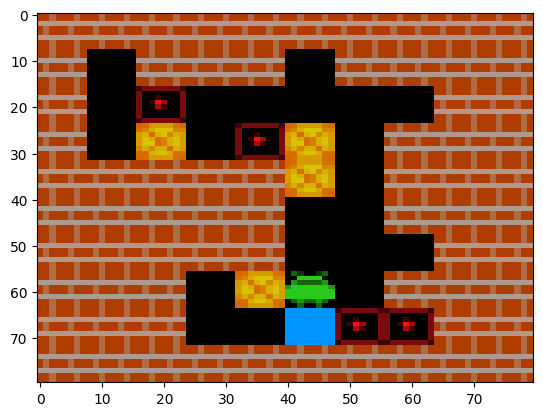

In [34]:
util.plot_raw_state(x[0].float())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

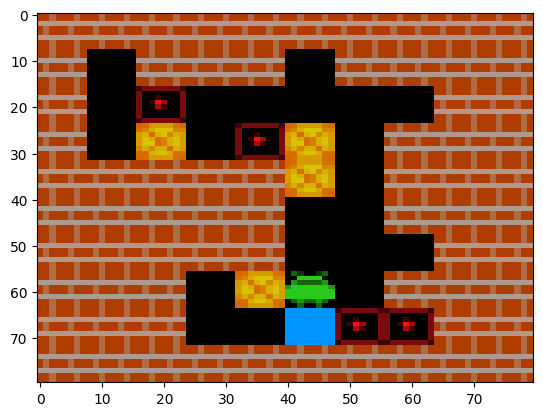

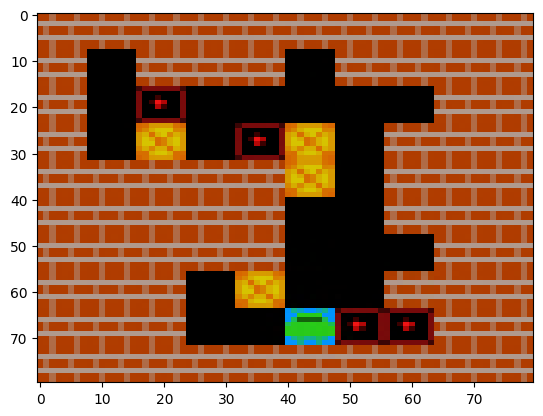

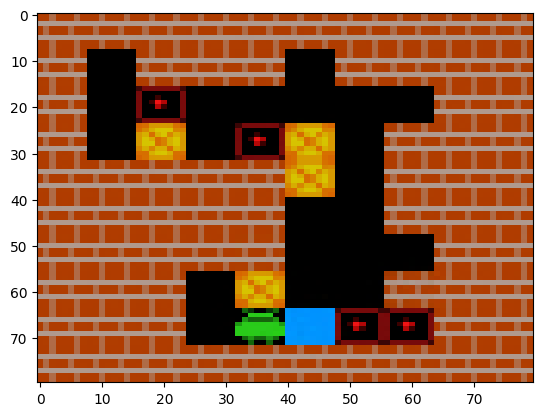

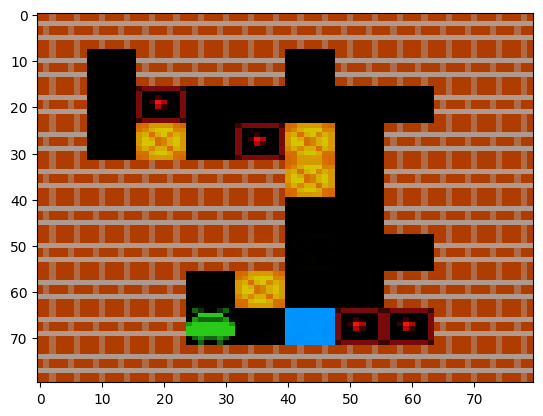

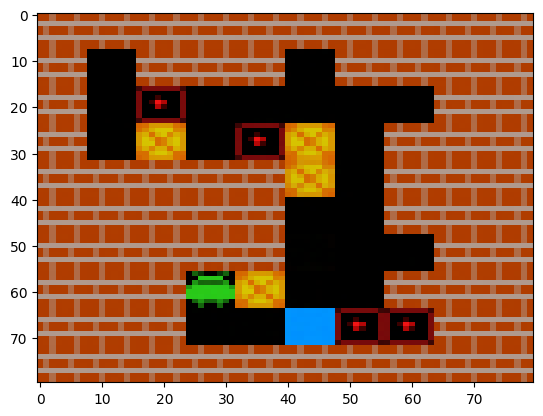

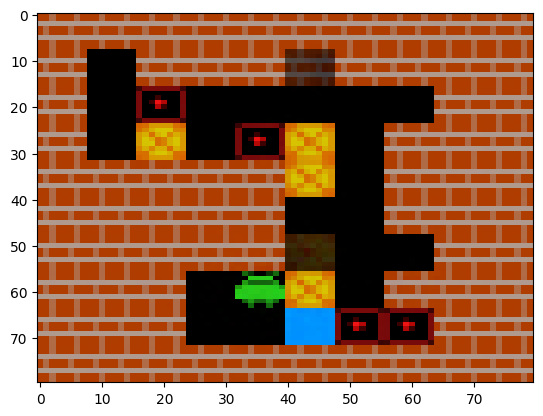

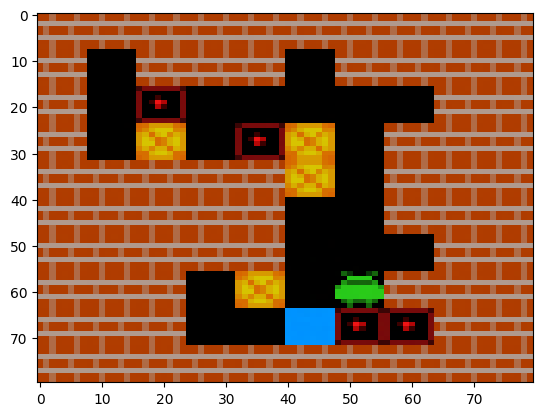

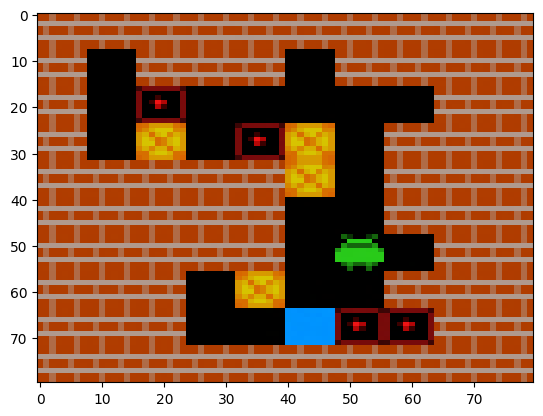

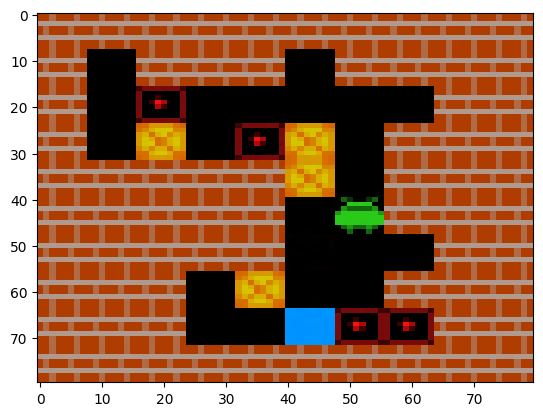

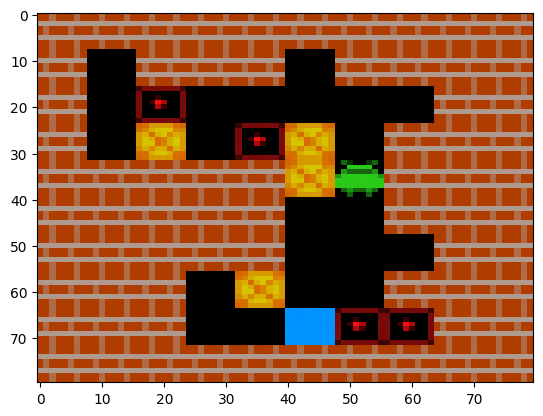

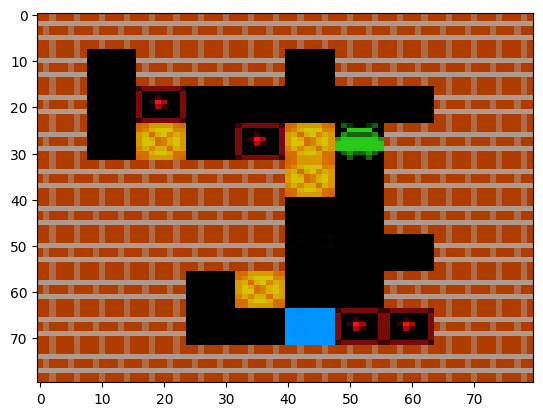

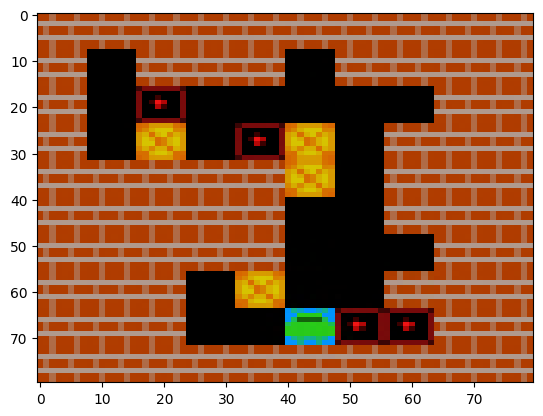

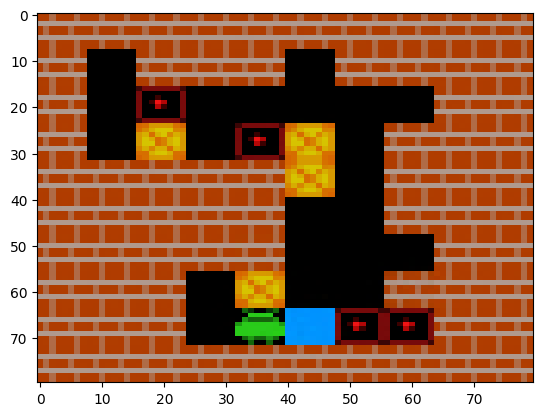

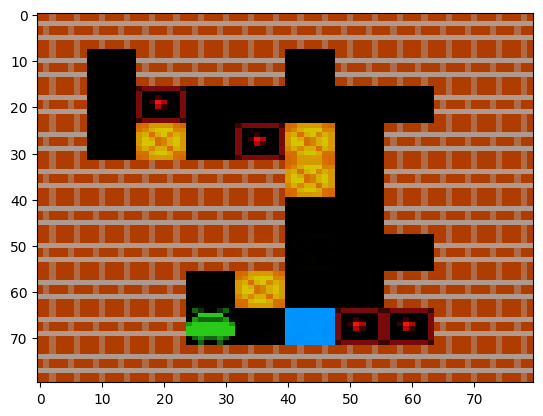

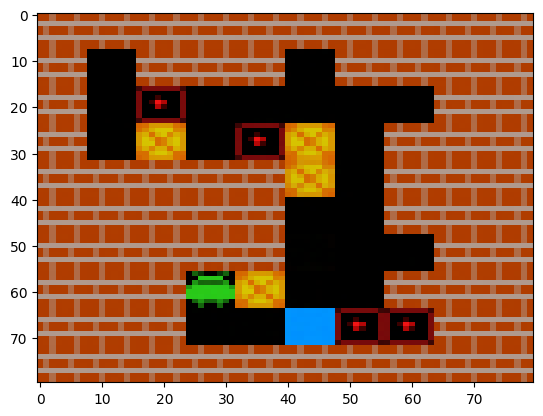

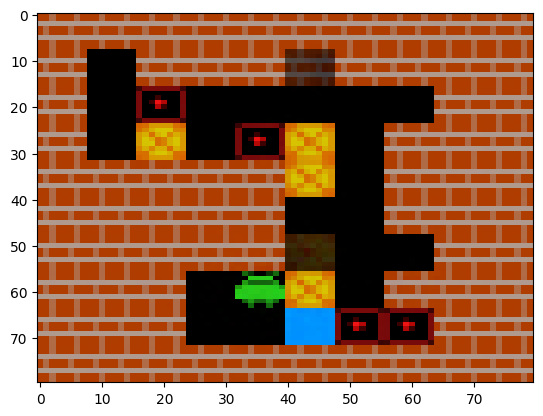

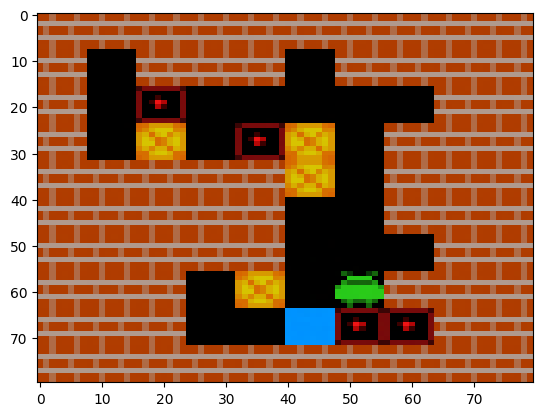

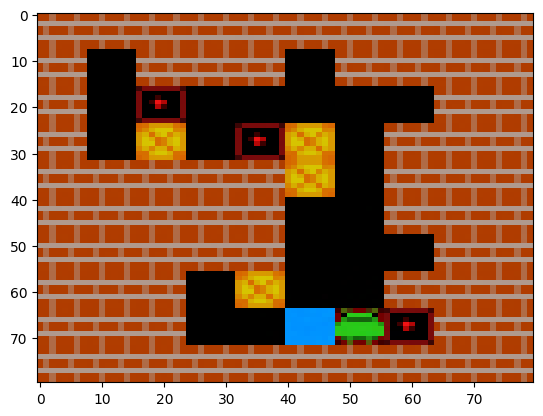

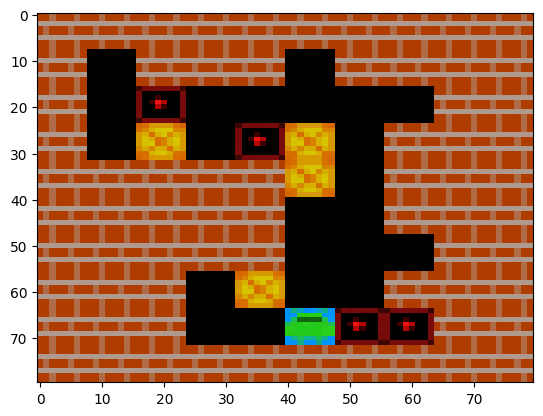

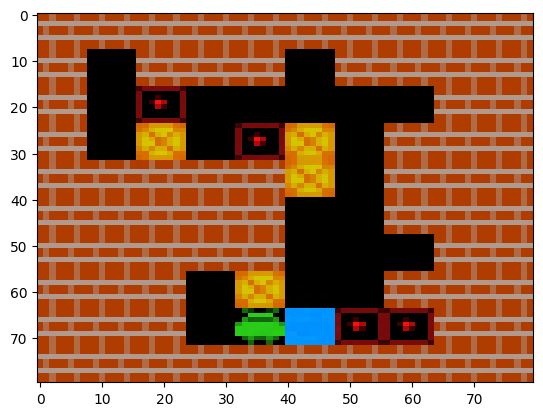

In [15]:
from thinker import util
idx = 1
for m in range(20):
    #print("future_cost", y[idx+m].item(), "cost", dataset[idx+m][0]["cost"][0].item())
    util.plot_raw_state(dataset[idx][0]["env_state"][m].float())


In [2]:
flags = argparse.Namespace()

# ========================================================

flags.dxpid = "v5_sok-23691168-0"
flags.dproject = "detect"
flags.datadir = "../data/__dproject__/__dxpid__/"
flags.txpid = "test"
flags.project = "detect_post"
flags.batch_size = 128
flags.learning_rate = 0.0001
flags.num_epochs = 50
flags.early_stop_n = -1
flags.data_n = 50000
flags.ckp = False
flags.use_wandb = False
flags.tran_layer_n = 3
flags.tran_ff_n = 512
flags.shallow_encode = False

flags.datadir = flags.datadir.replace("__dproject__", flags.dproject)
flags.datadir = flags.datadir.replace("__dxpid__", flags.dxpid)
# ========================================================
if not flags.ckp:
    flags.datadir = os.path.abspath(os.path.expanduser(flags.datadir))
    # create ckp dir
    xpid_n = 0
    while (True):
        xpid_ = flags.txpid if xpid_n == 0 else flags.txpid + f"_{xpid_n}"
        ckpdir = os.path.join(flags.datadir, xpid_)
        xpid_n += 1
        if not os.path.exists(ckpdir):
            os.mkdir(ckpdir) 
            flags.txpid = xpid_
            break    
else:
    ckpdir = os.path.join(flags.datadir, flags.txpid)
flags.tckpdir = ckpdir
flags.tckp_path = os.path.join(ckpdir, "ckp_detect.tar")
flags.tckp_path_b = os.path.join(ckpdir, "ckp_detect_best.tar")
print(f"Checkpoint path: {flags.tckp_path}")


Checkpoint path: /mnt/c/Users/chung/Personal/RS/thinker/data/detect/v5_sok-23691168-0/test/ckp_detect.tar


In [3]:
dataset = CustomDataset(datadir=flags.datadir, transform=None, data_n=10000)
dataloader = DataLoader(dataset, batch_size=flags.batch_size, shuffle=True)

Starting to preload data_0.pt


In [4]:
xs, y = next(iter(dataloader))

In [9]:
xs["env_state"][1,0].float.shape

torch.Size([3, 80, 80])

In [ ]:
for s in range(20):
    util.plot_raw_state((xs["env_state"][100,s].float()*255).long())

In [ ]:

# load data
dataset = CustomDataset(datadir=flags.datadir, transform=None, data_n=flags.data_n)
dataloader = DataLoader(dataset, batch_size=flags.batch_size, shuffle=True)

val_dataset = CustomDataset(datadir=flags.datadir, transform=None, data_n=5000, prefix="val")
val_dataloader = DataLoader(val_dataset, batch_size=flags.batch_size, shuffle=True)


In [ ]:

# load setting
yaml_file_path = os.path.join(flags.datadir, 'config_detect.yaml')
with open(yaml_file_path, 'r') as file:
    flags_data = yaml.safe_load(file)
flags_data = argparse.Namespace(**flags_data)
flags = argparse.Namespace(**{**vars(flags), **vars(flags_data)}) # merge the two flags

plogger = FileWriter(
    xpid=flags.txpid,
    xp_args=flags.__dict__,
    rootdir=flags.datadir,
    overwrite=not flags.ckp,
)
flags.full_xpid = flags.dxpid + "_" + flags.txpid

if flags.use_wandb: wlogger = util.Wandb(flags)

# initalize net
device = torch.device("cuda")
detect_net = DetectNet(
    env_state_shape = flags_data.env_state_shape,
    tree_rep_shape = getattr(flags_data, "tree_rep_shape", None),
    hidden_state_shape = getattr(flags_data, "hidden_state_shape", None),
    dim_actions = flags_data.dim_actions,
    num_actions = flags_data.num_actions,
    disable_thinker = flags.disable_thinker,
    tran_layer_n = flags.tran_layer_n,
    tran_ff_n = flags.tran_ff_n,
    shallow_encode= flags.shallow_encode,
)

# load optimizer
optimizer = torch.optim.Adam(
    detect_net.parameters(), lr=flags.learning_rate, 
)

if flags.ckp:
    checkpoint = torch.load(flags.tckp_path, torch.device("cpu"))
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    detect_net.load_state_dict(checkpoint["net_state_dict"])
    epoch = checkpoint["epoch"]
    del checkpoint
else:
    epoch = 0

detect_net = detect_net.to(device)
util.optimizer_to(optimizer, device)

print("Detect network size: %d"
        % sum(p.numel() for p in detect_net.parameters())
    )

best_val_loss = float('inf')
epoch_since_improve = 0

while (epoch < flags.num_epochs):
    train_stat = train_epoch(detect_net, dataloader, optimizer, device, flags, train=True)
    val_stat = train_epoch(detect_net, val_dataloader, None, device, flags, train=False)
    stat = {**train_stat, **{'val/' + key: value for key, value in val_stat.items()}}
    stat["epoch"] = epoch
    plogger.log(stat)
    if flags.use_wandb: wlogger.wandb.log(stat, step=stat['epoch'])
    
    epoch += 1    
    print_str = f'Epoch {epoch}/{flags.num_epochs},'
    for key in stat.keys(): 
        if 'val/' + key in stat.keys():
            print_str += f" {key}:{stat[key]:.4f} ({stat['val/'+key]:.4f})"
    print(print_str)   
            
    # Early stopping and best model saving logic
    if flags.early_stop_n >= 0:  # Check if early stopping is enabled
        current_val_loss = val_stat['loss']  # Assuming val_stat contains the validation loss
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            epoch_since_improve = 0
            save_ckp(flags.tckp_path_b, epoch, flags, optimizer, detect_net)
            print(f"New best model saved to {flags.tckp_path_b}")
        else:
            epoch_since_improve += 1
        
        if epoch_since_improve > flags.early_stop_n:
            print(f"Stopping early at epoch {epoch} due to no improvement in validation loss for {flags.early_stop_n} consecutive epochs.")
            break  # Stop the training loop

    if epoch % 5 == 0 or epoch >= flags.num_epochs:
        save_ckp(flags.tckp_path, epoch, flags, optimizer, detect_net)
        print(f"Checkpoint saved to {flags.tckp_path}")

    if flags.use_wandb and (epoch % 10 == 0 or epoch >= flags.num_epochs):
        wlogger.wandb.save(
            os.path.join(flags.tckpdir, "*"), flags.tckpdir
        )

In [14]:
# deprecated

import os 
from torch.utils.data import Dataset, DataLoader
import torch
from thinker import util

datadir = "../data/detect/v5_sok-5993808-1/"
datadir = os.path.abspath(os.path.expanduser(datadir))

class CustomDataset(Dataset):
    def __init__(self, datadir, transform=None):
        self.datadir = datadir
        self.file_list = [f for f in os.listdir(datadir) if f.endswith('.pt')]
        self.transform = transform
        xs, y = torch.load(os.path.join(datadir, self.file_list[0]))        
        self.t = xs['env_state'].shape[0]
        self.b = xs['env_state'].shape[2]
        self.samples_per_file = self.t * self.b

    def __len__(self):
        return len(self.file_list) * self.samples_per_file  # Adjust based on your data

    def __getitem__(self, idx):
        file_idx = idx // self.samples_per_file
        within_file_idx = idx % self.samples_per_file
        t_idx = within_file_idx // self.b
        b_idx = within_file_idx % self.b
        xs, y = torch.load(os.path.join(self.datadir, self.file_list[file_idx]))
        xs.pop('step_status')
        xs.pop('done')
        xs = util.dict_map(xs, lambda x: x[t_idx, :, b_idx])
        y = y[t_idx, b_idx]
        return xs, y

# To load data and train
dataset = CustomDataset(datadir)
# print(dataset[100])
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
train_features, train_labels = next(iter(train_dataloader))


0.2288818359375

In [25]:
from thinker.actor_net import DRCNet, ActorNetBase
from thinker.main import Env
from thinker.self_play import init_env_out, create_env_out
from thinker import util
import torch
import numpy as np

env_n = 16
flags = util.create_setting(args=[], drc=False, save_flags=False, see_h=True, legacy=True, wrapper_type=0, has_action_seq=False)
env = Env(
        name="Sokoban-v0",
        env_n=env_n,
        gpu=True,
        train_model=False,
        parallel=False,
        return_x=True,
        return_h=True,
        flags=flags,
    )

obs_space = env.observation_space
action_space = env.action_space 

device = torch.device("cuda")
# actor_net = DRCNet(obs_space=obs_space, action_space=action_space, flags=flags, tree_rep_meaning=None)
actor_net = ActorNetBase(obs_space=obs_space, action_space=action_space, flags=flags, tree_rep_meaning=None)


Initializing env 0 with device cuda
Model network size: 6637133


Symlinked log directory: /home/stephen/RS/thinker/notebook/logs/latest
Wrote config file to /home/stephen/RS/thinker/notebook/logs/detect-20240205-143653/config_c.yaml


In [26]:
obs_space["tree_reps"]

Box(-inf, inf, (16, 111), float32)

In [19]:
state_dict = torch.load("../logs/detect/v1a_base_dirloss/ckp_actor.tar")["actor_net_state_dict"]
new_state_dict = {}
for key, value in state_dict.items():
    key = key.replace("actor_encoder", "h_encoder")
    key = key.replace("core", "tree_rep_encoder.rnn")    
    key = key.replace("initial_enc", "tree_rep_encoder.rnn_in_fc")    
    key = key.replace("model_stat_fc", "tree_rep_encoder.rnn_out_fc")    
    new_state_dict[key] = value
actor_net.load_state_dict(new_state_dict)

RuntimeError: Error(s) in loading state_dict for ActorNetBase:
	size mismatch for tree_rep_encoder.rnn_in_fc.0.weight: copying a param with shape torch.Size([128, 79]) from checkpoint, the shape in current model is torch.Size([128, 111]).
	size mismatch for policy.weight: copying a param with shape torch.Size([5, 398]) from checkpoint, the shape in current model is torch.Size([5, 393]).
	size mismatch for im_policy.weight: copying a param with shape torch.Size([5, 398]) from checkpoint, the shape in current model is torch.Size([5, 393]).
	size mismatch for reset.weight: copying a param with shape torch.Size([2, 398]) from checkpoint, the shape in current model is torch.Size([2, 393]).
	size mismatch for baseline.weight: copying a param with shape torch.Size([2, 398]) from checkpoint, the shape in current model is torch.Size([2, 393]).

In [9]:
for k, v in actor_net.state_dict().items():
    print(k, v.shape)

x_encoder_pre.frame_encoder.conv1.weight torch.Size([64, 3, 3, 3])
x_encoder_pre.frame_encoder.conv1.bias torch.Size([64])
x_encoder_pre.frame_encoder.res1.0.conv1.weight torch.Size([64, 64, 3, 3])
x_encoder_pre.frame_encoder.res1.0.bn1.weight torch.Size([64])
x_encoder_pre.frame_encoder.res1.0.bn1.bias torch.Size([64])
x_encoder_pre.frame_encoder.res1.0.bn1.running_mean torch.Size([64])
x_encoder_pre.frame_encoder.res1.0.bn1.running_var torch.Size([64])
x_encoder_pre.frame_encoder.res1.0.bn1.num_batches_tracked torch.Size([])
x_encoder_pre.frame_encoder.res1.0.conv2.weight torch.Size([64, 64, 3, 3])
x_encoder_pre.frame_encoder.res1.0.bn2.weight torch.Size([64])
x_encoder_pre.frame_encoder.res1.0.bn2.bias torch.Size([64])
x_encoder_pre.frame_encoder.res1.0.bn2.running_mean torch.Size([64])
x_encoder_pre.frame_encoder.res1.0.bn2.running_var torch.Size([64])
x_encoder_pre.frame_encoder.res1.0.bn2.num_batches_tracked torch.Size([])
x_encoder_pre.frame_encoder.conv2.weight torch.Size([128,

In [6]:
for k, v in new_state_dict.items():
    print(k, v.shape)

x_encoder_pre.feat_convs.0.0.weight torch.Size([64, 256, 3, 3])
x_encoder_pre.feat_convs.0.0.bias torch.Size([64])
x_encoder_pre.feat_convs.1.0.weight torch.Size([64, 64, 3, 3])
x_encoder_pre.feat_convs.1.0.bias torch.Size([64])
x_encoder_pre.feat_convs.2.0.weight torch.Size([32, 64, 3, 3])
x_encoder_pre.feat_convs.2.0.bias torch.Size([32])
x_encoder_pre.resnet1.0.1.weight torch.Size([64, 64, 3, 3])
x_encoder_pre.resnet1.0.1.bias torch.Size([64])
x_encoder_pre.resnet1.0.3.weight torch.Size([64, 64, 3, 3])
x_encoder_pre.resnet1.0.3.bias torch.Size([64])
x_encoder_pre.resnet1.1.1.weight torch.Size([64, 64, 3, 3])
x_encoder_pre.resnet1.1.1.bias torch.Size([64])
x_encoder_pre.resnet1.1.3.weight torch.Size([64, 64, 3, 3])
x_encoder_pre.resnet1.1.3.bias torch.Size([64])
x_encoder_pre.resnet1.2.1.weight torch.Size([32, 32, 3, 3])
x_encoder_pre.resnet1.2.1.bias torch.Size([32])
x_encoder_pre.resnet1.2.3.weight torch.Size([32, 32, 3, 3])
x_encoder_pre.resnet1.2.3.bias torch.Size([32])
x_encoder

In [23]:
checkpoint = torch.load("../logs/detect/v1a_base_dirloss/ckp_actor.tar")["actor_net_state_dict"]
print(checkpoint)

OrderedDict([('actor_encoder.feat_convs.0.0.weight', tensor([[[[ 1.2713e-02,  1.1322e-02, -1.1810e-02],
          [ 4.2515e-03, -6.4119e-03,  3.2680e-03],
          [ 1.5939e-02, -6.3566e-03,  2.5855e-03]],

         [[ 4.1840e-03, -7.6971e-03, -2.6539e-02],
          [-1.5539e-02,  6.3376e-03, -1.1759e-02],
          [ 1.7228e-02,  1.2830e-02,  1.9434e-02]],

         [[-2.1108e-02, -1.4643e-02,  4.4190e-03],
          [ 3.1163e-03, -1.9116e-02, -2.9980e-02],
          [-7.3023e-03, -1.1445e-03,  7.1268e-03]],

         ...,

         [[-7.9039e-03, -1.5660e-02, -3.5266e-04],
          [-1.0154e-03, -2.2890e-02,  8.2255e-03],
          [ 9.9117e-03, -6.1810e-03,  1.6091e-02]],

         [[-1.3445e-03,  3.1131e-03,  1.2810e-02],
          [-8.6919e-03,  1.5786e-02, -2.5897e-02],
          [-2.8960e-05,  7.7775e-03,  9.7298e-03]],

         [[-8.3414e-03,  7.1531e-04,  4.3451e-03],
          [ 1.9111e-02,  5.4846e-04,  2.0524e-02],
          [ 3.8056e-02,  2.4751e-02,  3.9364e-02]]],




In [ ]:
actor_net = actor_net.to(device)
state = env.reset()
env_out = init_env_out(state, flags=flags, dim_actions=actor_net.dim_actions, tuple_action=actor_net.tuple_action)  
actor_state = actor_net.initial_state(batch_size=env_n, device=device)
rets = []

with torch.set_grad_enabled(False):
    
    while(True):
        actor_out, actor_state = actor_net(env_out=env_out, core_state=actor_state, greedy=False)
        primary_action, reset_action = actor_out.action, None
        state, reward, done, info = env.step(
            primary_action=primary_action, 
            reset_action=reset_action)    
        if torch.any(done):
            rets.extend(info["episode_return"][done].cpu().tolist())            
            print(f"Episode {len(rets)}; Return  {np.mean(np.array(rets))}")
        env_out = create_env_out(primary_action, state, reward, done, info, flags=flags)

In [8]:
cs = ['step', 'real_step', 'actor_net_optimizer_state_dict', 'actor_net_scheduler_state_dict', 'actor_net_state_dict']
for c in cs: checkpoint_[c] = checkpoint[c]
torch.save(checkpoint_, "../logs/detect/v5b_sok_drc/ckp_actor.tar")


In [6]:
import numpy as np

actor_net = actor_net.to(device)
state = env.reset()
#env_out = init_env_out(state, flags=flags, dim_actions=actor_net.dim_actions, tuple_action=actor_net.tuple_action)  
env_out = init_env_out(state, flags=flags, dim_actions=1, tuple_action=False)  
actor_state = actor_net.initial_state(batch_size=env_n, device=device)
rets = []

with torch.set_grad_enabled(False):
    
    while(True):
        #actor_out, actor_state = actor_net(env_out=env_out, core_state=actor_state, greedy=False)
        #primary_action, reset_action = actor_out.action, None
        primary_action, actor_state = actor_net(obs=env_out, core_state=actor_state, greedy=False)
        primary_action = primary_action[0]
        reset_action = None

        state, reward, done, info = env.step(
            primary_action=primary_action, 
            reset_action=reset_action)    
        if torch.any(done):
            rets.extend(info["episode_return"][done].cpu().tolist())            
            print(f"Episode {len(rets)}; Return  {np.mean(np.array(rets))}")
        env_out = create_env_out(primary_action, state, reward, done, info, flags=flags)

Episode 1; Return  13.789999961853027
Episode 2; Return  13.78000020980835
Episode 3; Return  13.773333549499512
Episode 4; Return  13.760000228881836
Episode 5; Return  13.744000244140626
Episode 6; Return  13.730000178019205
Episode 8; Return  13.710000038146973
Episode 9; Return  13.700000021192762
Episode 11; Return  13.683636491948908
Episode 12; Return  13.674166758855185
Episode 13; Return  13.680000085097094
Episode 15; Return  13.670000076293945
Episode 16; Return  13.658750057220459
Episode 17; Return  13.662353010738597
Episode 18; Return  13.651666747199165
Episode 19; Return  13.654210592571058
Episode 20; Return  13.655500078201294
Episode 21; Return  13.652857235499791
Episode 23; Return  13.656087046084197
Episode 24; Return  13.651250084241232
Episode 25; Return  13.649200096130372
Episode 26; Return  13.650769343742958
Episode 27; Return  13.653703795539009
Episode 28; Return  13.652857235499791
Episode 30; Return  13.649000072479248
Episode 32; Return  13.65656259655

KeyboardInterrupt: 